In [1]:
import os
import sys
sys.path.insert(0, '..')

from google.cloud import bigquery
from google.oauth2 import service_account

from google.cloud import bigquery
from google.oauth2 import service_account

import pandas as pd
import matplotlib.pyplot as plt
from decouple import config
import json
import numpy as np
import seaborn as sns

from sklearn.linear_model import LinearRegression

from authenticate_service_account import main
from utils import *

from sklearn.model_selection import train_test_split

from scipy import stats

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import r2_score


# Getting the data

## Query version

In [68]:
client = main()

query = """
SELECT *
FROM skyscanner-insights-343713.Itinerary_Scoring.top_10_ods
"""

query_job = client.query(query)

results = query_job.result()


In [69]:
gcp_data = results.to_dataframe()


In [76]:
gcp_data.to_csv("../raw_data/all_data_60_horizon", index=False)


In [78]:
new_data = pd.read_csv('../raw_data/all_data_60_horizon')


## Offline version

In [6]:
train_data = pd.read_csv("../raw_data/train_data_v1")
test_data = pd.read_csv("../raw_data/test_data_v1")

data = train_data.copy()


In [7]:
data.columns


Index(['Unnamed: 0', 'OriginApt', 'OriginCty', 'OriginCtry', 'DestinationApt',
       'DestinationCty', 'DestinationCtry', 'TravelHorizonDays',
       'TravelDistanceKm', 'SelfTransfer', 'Stops', 'DurationMin',
       'Seg_0_OriginIATA', 'Seg_0_OriginName', 'Seg_0_DestinationIATA',
       'Seg_0_DestinationName', 'Seg_0_OperatingCarrierIATA',
       'Seg_0_TravelDistanceKm', 'Seg_1_OriginIATA', 'Seg_1_OriginName',
       'Seg_1_DestinationIATA', 'Seg_1_DestinationName',
       'Seg_1_OperatingCarrierIATA', 'Seg_1_TravelDistanceKm',
       'Seg_2_OriginIATA', 'Seg_2_OriginName', 'Seg_2_DestinationIATA',
       'Seg_2_DestinationName', 'Seg_2_OperatingCarrierIATA',
       'Seg_2_TravelDistanceKm', 'Seg_3_OriginIATA', 'Seg_3_OriginName',
       'Seg_3_DestinationIATA', 'Seg_3_DestinationName',
       'Seg_3_OperatingCarrierIATA', 'Seg_3_TravelDistanceKm',
       'Seg_0_DurationMin', 'Seg_1_DurationMin', 'Seg_2_DurationMin',
       'Seg_3_DurationMin', 'passengers', 'SearchLowestRatio',
  

In [10]:
def create_train_test_no_split(df, random_states=42):
    """
    Returns train_data and test_data
    Input is the df
    If you wish, you can adjust the random state
    """

    train_data, test_data = train_test_split(df, test_size=0.2, random_state=random_states)

    return train_data, test_data


In [21]:
# train_data, test_data = create_train_test_no_split(data)


In [12]:
columns_for_model = ['OD', 'TravelDistanceKm', 'Stops', 'TravelHorizonDays',
                     'Seg_0_TravelDistanceKm', 'Seg_1_TravelDistanceKm', 'Seg_2_TravelDistanceKm', 'Seg_3_TravelDistanceKm',
                     'ItineraryRedirects', 'ODRedirects', 'PricePerPax',
                     'Seg_0_DurationMin' ,'Seg_1_DurationMin', 'Seg_2_DurationMin', 'Seg_3_DurationMin', 'DurationMin']


In [49]:
def ants_preprocess(data):
    data_with_od = create_od_column(data, ['OriginCty', 'DestinationCty'])

    data_with_layover = calculate_total_layover_time(data_with_od, as_ratio=True)

    data_with_layover2 = calculate_distance_difference(data_with_layover, as_ratio=True)

    data_with_redirect_ratio = redirect_ratio(data_with_layover2)

    droped_values = drop_neg_layover_time(data_with_redirect_ratio)

    return droped_values


In [91]:
clean_data = new_data.dropna(subset='TravelDistanceKm').copy()


In [239]:
basic_processing_data = ants_preprocess(clean_data)

# basic_processing_test_data = ants_preprocess(test_data)


In [51]:
# sorted_data = data_with_layover[data_with_layover['total_layover_time'] > 0]['total_layover_time'].sort_values()
# cumulative = np.arange(1, len(sorted_data) +1) / len(sorted_data)

# plt.figure(figsize=(10,6))
# plt.plot(sorted_data, cumulative)
# plt.yticks(np.linspace(0, 1, 11))
# x_values = [125, 250, 375, 500, 750, 1000, 1250, 1500]  # Replace x1, x2, x3 with your specific values
# for x in x_values:
#     plt.axvline(x=x, linestyle='--', alpha=0.3)

# y_values = [0.4, 0.5, 0.7, 0.8]
# for y in y_values:
#     plt.axhline(y=y, color='green', linestyle='--', alpha=0.3)

# plt.title("Cumulative distribution of layover times")
# plt.xlabel('Time')
# plt.ylabel('% share of the data')


# Creating a baseline model

In this model we are using unscaled, and simple columns as shown in the columns_for_model_baseline variable below

In [88]:
columns_for_model_baseline = ['Stops','DurationMin', 'total_layover_time_ratio',
                             'total_distance_traveled','extra_travel_distance_ratio',
                             'TravelHorizonDays', 'redirect_ratio']

baseline_data = basic_processing_data[columns_for_model_baseline].copy()

# baseline_test_data = basic_processing_test_data[columns_for_model_baseline].copy()

# plt.figure(figsize=(10, 8))

# sns.heatmap(baseline_data.corr(), annot=True,  fmt=".2f", cmap='coolwarm',
#             square=True, linewidths=.5, cbar_kws={"shrink": .5})

X_train, X_test, y_train, y_test = create_train_test_split(baseline_data, 'redirect_ratio')

# X_train = baseline_data.drop('redirect_ratio', axis=1)
# y_train = baseline_data['redirect_ratio']
# X_test = baseline_test_data.drop('redirect_ratio', axis=1)
# y_test = baseline_test_data['redirect_ratio']


In [89]:
baseline_model = LinearRegression()

baseline_model.fit(X_train, y_train)

y_pred = baseline_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("Baseline mse:", mse)
print("Coefficients:", baseline_model.coef_)


Baseline mse: 0.12659307915408818
Coefficients: [ 7.22404022e-02 -1.61689753e-04  2.31980699e-01  1.18691786e-05
  1.79560901e-02  3.03571600e-03]


In [90]:
r2_score(y_test, y_pred)


0.03422551403097063

## Baseline conclusions

Model is performing terribly with an mse of 0.020614984406709863, which is high relative to our target which is between 0-1

Coefficients suggest that order of feature importance goes
1. Stops
2. extra_travel_distance_ratio
3. Total_layover_time_ratio
4. TravelHorizonDays
5. DurationMin
6. total_distance_traveled

# Model v1

Dropping total_distance_traveled as it was the least useful - it was an oversight to include it. 
Now going to scale the data and see the difference

In [55]:
columns_for_model_v1 = ['Stops','DurationMin', 'total_layover_time_ratio',
                             'extra_travel_distance_ratio',
                             'TravelHorizonDays', 'redirect_ratio']

v1_train_data = basic_processing_train_data[columns_for_model_v1].copy()
x_train_values = v1_train_data.drop('redirect_ratio', axis=1)

v1_test_data = basic_processing_test_data[columns_for_model_v1].copy()
x_test_values = v1_test_data.drop('redirect_ratio', axis=1)

minmax_train_scaler = MinMaxScaler()
minmax_scaled_train_data = minmax_train_scaler.fit_transform(x_train_values)

minmax_test_scaler = MinMaxScaler()
minmax_scaled_test_data = minmax_test_scaler.fit_transform(x_test_values)

X_train_v1 = minmax_scaled_train_data
y_train_v1 = v1_train_data['redirect_ratio']
X_test_v1 = minmax_scaled_test_data
y_test_v1 = v1_test_data['redirect_ratio']


In [56]:

# X_train_v1, X_test_v1, y_train_v1, y_test_v1 = train_test_split(minmax_scaled_train_data, v1_train_data['redirect_ratio'])


In [57]:
v1_model = LinearRegression()

v1_model.fit(X_train_v1, y_train_v1)

y_pred_v1 = v1_model.predict(X_test_v1)

mse_v1 = mean_squared_error(y_test_v1, y_pred_v1)
print("Baseline mse:", mse_v1)
print("Coefficients:", v1_model.coef_)


Baseline mse: 0.020599653401785156
Coefficients: [-0.1192257  -0.08470712  0.00386804  0.10899612  0.39743505]


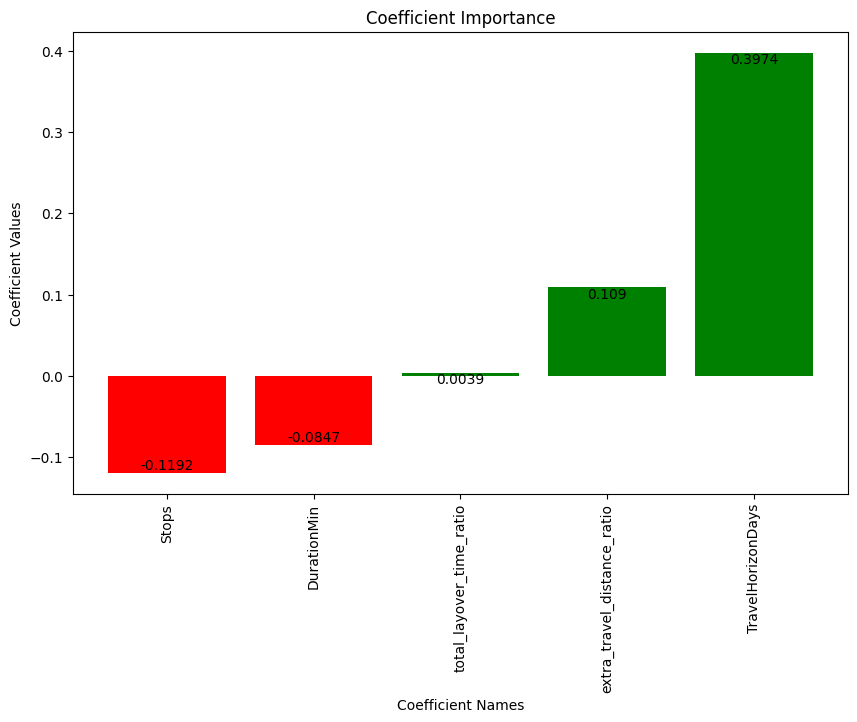

In [58]:
# Coefficients and their corresponding names (example names)
coefficients = v1_model.coef_
names = v1_train_data.drop('redirect_ratio', axis=1).columns

# Creating the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(names, coefficients, color=['red' if x < 0 else 'green' for x in coefficients])

# Adding labels and title
plt.xlabel('Coefficient Names')
plt.ylabel('Coefficient Values')
plt.title('Coefficient Importance')


# Annotating each bar with its value
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 4), va='bottom' if yval < 0 else 'top', ha='center')

plt.xticks(rotation=90)
# Showing the plot
plt.show()


In [59]:
r2_score(y_test_v1, y_pred_v1)


0.3057872096526705

## model v2

### MORE DATA!

Plan here:
1. Encode the airports for the OD's
2. Filter out ODRedirects that are less than 5

In [93]:
#
OD_redirecst_5_mask = basic_processing_data['ODRedirects'] > 5
more_than_5_OD_redirects = basic_processing_data[OD_redirecst_5_mask]

# Removing perfect redirect ratios as they may confuse the model
# perfect_redirect_ratio_mask = more_than_5_OD_redirects['redirect_ratio']==1
# filtered_data = more_than_5_OD_redirects[perfect_redirect_ratio_mask]


In [94]:
more_than_5_OD_redirects.columns


Index(['OriginApt', 'OriginCty', 'OriginCtry', 'DestinationApt',
       'DestinationCty', 'DestinationCtry', 'TravelHorizonDays',
       'TravelDistanceKm', 'SelfTransfer', 'Stops', 'DurationMin',
       'Seg_0_OriginIATA', 'Seg_0_OriginName', 'Seg_0_DestinationIATA',
       'Seg_0_DestinationName', 'Seg_0_OperatingCarrierIATA',
       'Seg_0_TravelDistanceKm', 'Seg_1_OriginIATA', 'Seg_1_OriginName',
       'Seg_1_DestinationIATA', 'Seg_1_DestinationName',
       'Seg_1_OperatingCarrierIATA', 'Seg_1_TravelDistanceKm',
       'Seg_2_OriginIATA', 'Seg_2_OriginName', 'Seg_2_DestinationIATA',
       'Seg_2_DestinationName', 'Seg_2_OperatingCarrierIATA',
       'Seg_2_TravelDistanceKm', 'Seg_3_OriginIATA', 'Seg_3_OriginName',
       'Seg_3_DestinationIATA', 'Seg_3_DestinationName',
       'Seg_3_OperatingCarrierIATA', 'Seg_3_TravelDistanceKm',
       'Seg_0_DurationMin', 'Seg_1_DurationMin', 'Seg_2_DurationMin',
       'Seg_3_DurationMin', 'passengers', 'SearchLowestRatio',
       'ItinLowe

In [130]:
columns_for_model_v1 = ['Stops','DurationMin', 'total_layover_time_ratio', 'extra_travel_distance_ratio',
                        'TravelHorizonDays','OriginApt', 'DestinationApt', 'TravelDistanceKm',
                        'redirect_ratio']


In [145]:
good_columns = basic_processing_data[columns_for_model_v1]


In [146]:
good_columns


,Stops,DurationMin,total_layover_time_ratio,extra_travel_distance_ratio,TravelHorizonDays,OriginApt,DestinationApt,TravelDistanceKm,redirect_ratio
386,1,335,0.552239,1.006519,9,AAE,ORN,767.0,1.000000
387,0,145,0.000000,1.000000,2,AAE,CDG,1420.0,0.058824
388,1,450,0.600000,1.000000,2,AAE,CDG,1420.0,0.058824
389,1,400,0.562500,1.005634,2,AAE,CDG,1420.0,0.058824
390,1,245,0.326531,1.000000,2,AAE,ORY,1396.0,0.117647
...,...,...,...,...,...,...,...,...,...
2580499,0,120,0.000000,1.000000,5,ZUH,KMG,1133.0,0.800000
2580500,0,80,0.000000,1.000000,21,ZUH,KOW,461.0,1.000000
2580501,0,690,0.000000,1.000000,7,ZYL,MAN,8070.0,1.000000
2580502,3,1355,0.365314,1.168278,17,ZYL,MAN,8070.0,0.333333


In [148]:
import category_encoders as ce


In [149]:
o_encoder = ce.BinaryEncoder(cols=['OriginApt'])
df_binary = o_encoder.fit_transform(good_columns)

d_encoder = ce.BinaryEncoder(cols=['DestinationApt'])
all_binary = d_encoder.fit_transform(df_binary)


In [150]:
columns_to_scale = ['Stops', 'DurationMin', 'TravelHorizonDays']

# minmax_scaler = MinMaxScaler()
# scaled_columns = minmax_scaler.fit_transform(all_binary[columns_to_scale])

# all_binary[columns_to_scale] = scaled_columns

all_binary


,Stops,DurationMin,total_layover_time_ratio,extra_travel_distance_ratio,TravelHorizonDays,OriginApt_0,OriginApt_1,OriginApt_2,OriginApt_3,OriginApt_4,...,DestinationApt_4,DestinationApt_5,DestinationApt_6,DestinationApt_7,DestinationApt_8,DestinationApt_9,DestinationApt_10,DestinationApt_11,TravelDistanceKm,redirect_ratio
386,1,335,0.552239,1.006519,9,0,0,0,0,0,...,0,0,0,0,0,0,0,1,767.0,1.000000
387,0,145,0.000000,1.000000,2,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1420.0,0.058824
388,1,450,0.600000,1.000000,2,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1420.0,0.058824
389,1,400,0.562500,1.005634,2,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1420.0,0.058824
390,1,245,0.326531,1.000000,2,0,0,0,0,0,...,0,0,0,0,0,0,1,1,1396.0,0.117647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2580499,0,120,0.000000,1.000000,5,0,1,1,1,0,...,1,1,0,0,0,1,1,0,1133.0,0.800000
2580500,0,80,0.000000,1.000000,21,0,1,1,1,0,...,0,1,0,0,1,0,1,0,461.0,1.000000
2580501,0,690,0.000000,1.000000,7,0,1,0,1,1,...,0,0,0,1,1,1,0,1,8070.0,1.000000
2580502,3,1355,0.365314,1.168278,17,0,1,0,1,1,...,0,0,0,1,1,1,0,1,8070.0,0.333333


In [151]:
X_train_v2, X_test_v2, y_train_v2, y_test_v2 = train_test_split(all_binary.drop('redirect_ratio',
                                                                                axis=1), all_binary['redirect_ratio'])

v2_model = LinearRegression()

v2_model.fit(X_train_v2, y_train_v2)

y_pred_v2 = v2_model.predict(X_test_v2)

mse_v2 = mean_squared_error(y_test_v2, y_pred_v2)
print("Baseline mse:", mse_v2)
print("Coefficients:", v2_model.coef_)


Baseline mse: 0.11556328415109823
Coefficients: [ 6.53428879e-02 -1.29490224e-04  1.87585857e-01  1.90411209e-02
  3.24547636e-03  4.67672025e-01  8.91784584e-02 -1.28778202e-02
  4.40014228e-02  1.75795394e-02  5.50699398e-03 -1.74250987e-02
 -1.36043880e-02 -2.03084755e-03  2.45666885e-03  8.35333520e-04
 -4.46359466e-03  5.09283070e-01  2.57084606e-01  1.44948378e-01
  9.90300651e-02  3.68068939e-02  6.66935085e-02  1.38789263e-02
 -2.29255184e-02 -2.12590085e-02  1.12154574e-02  1.43266363e-02
 -6.49986304e-03  1.50015097e-05]


In [152]:
r2_score(y_test_v2, y_pred_v2)


0.115909510085484

In [153]:
import xgboost as xgb


In [154]:
model_xg = xgb.XGBRegressor(objective ='reg:squarederror')

# Train the model
model_xg.fit(X_train_v2, y_train_v2)

# Make predictions
y_pred_v2 = model_xg.predict(X_test_v2)

# Evaluate the model
rmse = mean_squared_error(y_test_v2, y_pred_v2, squared=False)


In [155]:
rmse, r2_score(y_test_v2, y_pred_v2)


(0.29453430794750635, 0.3363354462419432)

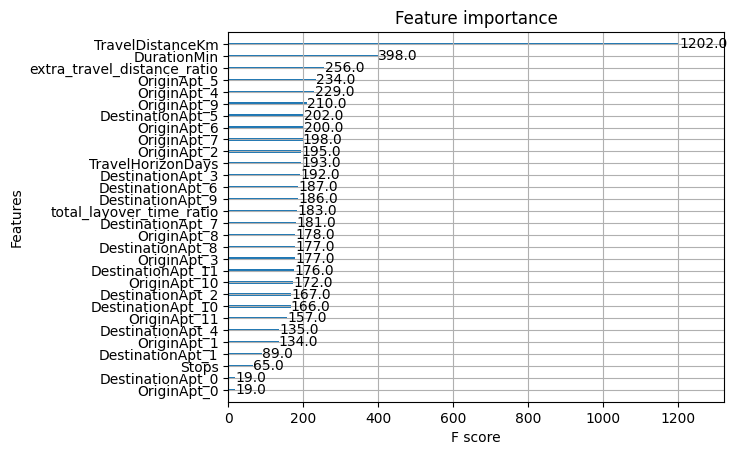

In [157]:
feature_importance = model_xg.feature_importances_

# Visualize feature importance
xgb.plot_importance(model_xg)
plt.show()


# model v3

Try clustering models, but include ODRedirects

In [291]:
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import accuracy_score


In [282]:
columns_for_model_knn = ['DurationMin', 'total_layover_time_ratio', 'extra_travel_distance_ratio',
                        'TravelHorizonDays','OriginApt', 'DestinationApt', 'TravelDistanceKm', 'od_pop',
                        'redirect_ratio']


In [271]:
od_competitivness = pd.DataFrame(basic_processing_data['OD'].value_counts()).reset_index()


In [264]:
od_popularity = pd.DataFrame(basic_processing_data.groupby('OD')['ODRedirects'].sum()).reset_index().set_index('OD')
# od_popularity.rename(columns={'ODRedirects':'Popularity'}, inplace=True)
# od_popularity['OD'] = od_popularity['OD'].astype('str')


In [265]:
new_column = []

for i in range(len(basic_processing_data)):
    od_name = basic_processing_data.iloc[i]['OD']
    value = od_popularity.loc[od_name][0]

    new_column.append(value)


/var/folders/62/d7t21rj54ls65fhypjm4ryb00000gn/T/ipykernel_35554/3823882541.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  value = od_popularity.loc[od_name][0]


In [277]:
basic_processing_data['od_pop'] = new_column


In [283]:
good_columns_knn = basic_processing_data[columns_for_model_knn]


In [284]:
good_columns_knn.columns


Index(['DurationMin', 'total_layover_time_ratio',
       'extra_travel_distance_ratio', 'TravelHorizonDays', 'OriginApt',
       'DestinationApt', 'TravelDistanceKm', 'od_pop', 'redirect_ratio'],
      dtype='object')

In [287]:
o_encoder_knn = ce.BinaryEncoder(cols=['OriginApt'])
df_binary_knn = o_encoder_knn.fit_transform(good_columns_knn)

d_encoder_knn = ce.BinaryEncoder(cols=['DestinationApt'])
all_binary_knn = d_encoder_knn.fit_transform(df_binary_knn)


In [289]:
all_binary_knn.columns


Index(['DurationMin', 'total_layover_time_ratio',
       'extra_travel_distance_ratio', 'TravelHorizonDays', 'OriginApt_0',
       'OriginApt_1', 'OriginApt_2', 'OriginApt_3', 'OriginApt_4',
       'OriginApt_5', 'OriginApt_6', 'OriginApt_7', 'OriginApt_8',
       'OriginApt_9', 'OriginApt_10', 'OriginApt_11', 'DestinationApt_0',
       'DestinationApt_1', 'DestinationApt_2', 'DestinationApt_3',
       'DestinationApt_4', 'DestinationApt_5', 'DestinationApt_6',
       'DestinationApt_7', 'DestinationApt_8', 'DestinationApt_9',
       'DestinationApt_10', 'DestinationApt_11', 'TravelDistanceKm', 'od_pop',
       'redirect_ratio'],
      dtype='object')

In [292]:
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(all_binary_knn.drop('redirect_ratio',
                                                                                axis=1), all_binary_knn['redirect_ratio'])

# Creating the KNN classifier
k = 5  # Number of neighbors
knn = KNeighborsRegressor(n_neighbors=k)

# Fitting the model with training data
knn.fit(X_train_knn, y_train_knn)

# Making predictions on the test set
y_pred_knn = knn.predict(X_test_knn)

# Evaluating the model
accuracy_knn = accuracy_score(y_test_knn, y_pred_knn)
print(f"Accuracy: {accuracy_knn}")


ValueError: continuous is not supported

In [293]:
r2_score(y_true=y_test_knn, y_pred=y_pred_knn)


0.5871121932408243

In [301]:
mask = basic_processing_data['OD'] == 'BCNBUD'

basic_processing_data[mask]


,OriginApt,OriginCty,OriginCtry,DestinationApt,DestinationCty,DestinationCtry,TravelHorizonDays,TravelDistanceKm,SelfTransfer,Stops,...,ItineraryRedirects,ODRedirects,OD,total_travel_time,total_layover_time,total_layover_time_ratio,total_distance_traveled,extra_travel_distance_ratio,redirect_ratio,od_pop
2350,BCN,BCN,ES,BUD,BUD,HU,1,1522.0,False,0,...,9,20,BCNBUD,145.0,0.0,0.0,1522.0,1.0,0.450000,5882
2351,BCN,BCN,ES,BUD,BUD,HU,1,1522.0,False,0,...,4,20,BCNBUD,155.0,0.0,0.0,1522.0,1.0,0.200000,5882
2352,BCN,BCN,ES,BUD,BUD,HU,1,1522.0,False,0,...,1,20,BCNBUD,155.0,0.0,0.0,1522.0,1.0,0.050000,5882
2353,BCN,BCN,ES,BUD,BUD,HU,1,1522.0,False,0,...,5,20,BCNBUD,160.0,0.0,0.0,1522.0,1.0,0.250000,5882
2354,BCN,BCN,ES,BUD,BUD,HU,1,1522.0,False,0,...,1,20,BCNBUD,145.0,0.0,0.0,1522.0,1.0,0.050000,5882
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2454226,BCN,BCN,ES,BUD,BUD,HU,15,1522.0,False,0,...,5,35,BCNBUD,160.0,0.0,0.0,1522.0,1.0,0.142857,5882
2454227,BCN,BCN,ES,BUD,BUD,HU,15,1522.0,False,0,...,4,35,BCNBUD,155.0,0.0,0.0,1522.0,1.0,0.114286,5882
2454228,BCN,BCN,ES,BUD,BUD,HU,15,1522.0,False,0,...,9,35,BCNBUD,155.0,0.0,0.0,1522.0,1.0,0.257143,5882
2454229,BCN,BCN,ES,BUD,BUD,HU,15,1522.0,False,0,...,5,35,BCNBUD,160.0,0.0,0.0,1522.0,1.0,0.142857,5882


In [317]:
new_test = np.array(X_test_knn.iloc[2350]).reshape(1,-1)
new_test


array([[3.90000000e+02, 4.74358974e-01, 9.38618926e-01, 2.20000000e+01,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 0.00000000e+00,
        1.00000000e+00, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.95500000e+03, 5.00000000e+01]])

In [320]:
pred, indic = knn.kneighbors(new_test, return_distance=True)


/Users/antonis/.pyenv/versions/3.12.0/envs/OptiFlyAi/lib/python3.12/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


In [331]:
basic_processing_data.iloc[indic[0]]


,OriginApt,OriginCty,OriginCtry,DestinationApt,DestinationCty,DestinationCtry,TravelHorizonDays,TravelDistanceKm,SelfTransfer,Stops,...,ItineraryRedirects,ODRedirects,OD,total_travel_time,total_layover_time,total_layover_time_ratio,total_distance_traveled,extra_travel_distance_ratio,redirect_ratio,od_pop
1305645,NGO,NGO,JP,ICN,SEL,KR,12,973.0,False,0,...,16,31,NGOSEL,120.0,0.0,0.000000,973.0,1.000000,0.516129,18104
851161,ZAG,ZAG,HR,AMS,AMS,NL,19,1099.0,False,1,...,3,5,ZAGAMS,225.0,40.0,0.150943,1900.0,1.728844,0.600000,959
1563166,MNL,MNL,PH,YYZ,YTO,CA,24,13212.0,False,1,...,1,12,MNLYTO,990.0,285.0,0.223529,13253.0,1.003103,0.083333,3677
772993,HND,TYO,JP,PVG,SHA,CN,14,1736.0,False,0,...,4,17,TYOSHA,200.0,0.0,0.000000,1796.0,1.034562,0.235294,8999
1800224,FCO,ROM,IT,BCM,BCM,RO,5,1280.0,False,0,...,8,11,ROMBCM,135.0,0.0,0.000000,1280.0,1.000000,0.727273,94
